# **H&M 고객 이탈 예측 분석**

**"데이터 기반의 개인화 마케팅을 위한 고객 이탈 예측 시스템 구축"**

# **비즈니스 문제 정의**
- 패션 이커머스는 반복 구매가 핵심
- 고객 이탈은 매출 감소로 직결
- 이탈 위험 고객을 조기 탐지해야 함

## **Data Preparation**

In [2]:
import pandas as pd
import numpy as np

# 거래 데이터 불러오기
transactions=pd.read_parquet("./data/transactions_train.parquet")

In [3]:
# 거래 데이터 파악하기
print(transactions.shape)
print(transactions.columns)
print(transactions.info())
print(transactions.isnull().sum())

(31788324, 5)
Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB
None
t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64


*  't_dat' 컬럼은 object(문자열) 형식이기 때문에 계산이 불가능하다


>  따라서 **파이썬이 날짜로 인식 가능한 datetime 객체로 변환**해주자.


*  H&M 거래 데이터는 약 3,100만 건으로 대용량 데이터이다. 차후 customers, articles 데이터까지 합치게되면 메모리 부족 에러 발생이 가능하다.

> 따라서 **float32로 변환해서 메모리 부족으로 커널이 죽는 것은 방지**하자



In [4]:
# 날짜 타입 변환 ( 날짜 계산하려면 datetime 타입 )
transactions['t_dat']=pd.to_datetime(transactions['t_dat'])
# float32 로 변횐해서 메모리 부족으로 커널이 죽는 것 방지
transactions['price']=transactions['price'].astype('float32')

거래 데이터는 실시간 데이터가 아닌 과거에 멈춘 데이터셋이기 때문에, "왜 고객이 이탈했는가?"를 알려면  **"마지막 구매 후 며칠이 지났는가?"** 를 계산해야한다.

In [5]:
# 데이터 중에서 가장 최근 구매일 (2020-09-22)
latest_date=transactions['t_dat'].max()

'노이즈'를 제거해서 데이터 처리해보자

In [6]:
# 구매 건수의 상세 분포 확인
print("--- 구매 건수 구간별 통계 ---")
purchase_counts = transactions.groupby('customer_id')['article_id'].count()
print(purchase_counts.describe(percentiles=[0.5, 0.9, 0.95, 0.99, 0.999]))

--- 구매 건수 구간별 통계 ---
count    1.362281e+06
mean     2.333463e+01
std      3.924225e+01
min      1.000000e+00
50%      9.000000e+00
90%      6.000000e+01
95%      9.100000e+01
99%      1.870000e+02
99.9%    3.850000e+02
max      1.895000e+03
Name: article_id, dtype: float64


In [7]:
# 각 고객당 총 구매 건수가 담긴 데이터
purchase_counts = transactions.groupby('customer_id')['article_id'].count()
upper_limit = purchase_counts.quantile(0.999)
print(f"상위 0.1% 구매 건수 기준: {upper_limit}건")

상위 0.1% 구매 건수 기준: 385.0건


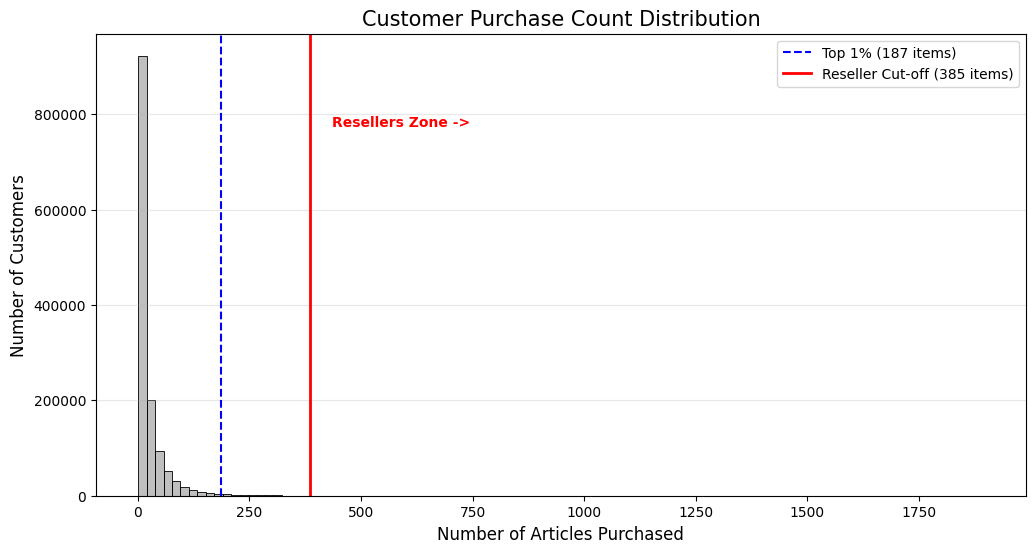

In [8]:
# 시각화 설정
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 6))

# 히스토그램 (Distribution)
sns.histplot(purchase_counts, bins=100, color='gray', alpha=0.5)

# 기준선 표시 (99%와 99.9%)
# 파란 선은 상위 1%지점 - ("이 정도면 많이 샀다")
plt.axvline(x=purchase_counts.quantile(0.99), color='blue', linestyle='--', label=f'Top 1% ({int(purchase_counts.quantile(0.99))} items)')
# 빨간 선은 상위 0.1%지점 [385건] - ("일반적인 고객이 아니다")
plt.axvline(x=upper_limit, color='red', linestyle='-', linewidth=2, label=f'Reseller Cut-off ({int(upper_limit)} items)')

# 텍스트 추가 (인사이트 강조)
plt.text(upper_limit + 50, plt.ylim()[1]*0.8, 'Resellers Zone ->', color='red', fontweight='bold')

plt.title('Customer Purchase Count Distribution', fontsize=15)
plt.xlabel('Number of Articles Purchased', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

**"H&M 의 수많은 고객 중 구매 건수가 가장 많은 극상위 0.1% 고객은 최소 385건 이상의 상품을 구매했다."**

'노이즈'를 제거하여 데이터 품질을 높여보자.

2년간 385벌 넘게 산 사람들을 **리셀러** 그룹으로 분류

In [9]:
# 385 건 이상 구매한 고객 리스트 추출
resellers = purchase_counts[purchase_counts > upper_limit].index
print(f"이상치 고객 {len(resellers)}명을 분석에서 제외하여 모델의 일반화 성능을 높인다.")

이상치 고객 1362명을 분석에서 제외하여 모델의 일반화 성능을 높인다.


In [10]:
# 리셀러 명단에 포함되지 않은(~isin) 데이터만 다시 저장
transactions = transactions[~transactions['customer_id'].isin(resellers)]

# 결과 확인
print(f"리셀러 제거 후 남은 거래 건수: {len(transactions):,}건")

리셀러 제거 후 남은 거래 건수: 31,097,423건


고객별로 다음 구매까지 며칠이 걸렸는지 계산하고, 각 구간별로 누적 확률 알아보자.

tmp [임시 변수 데이터]로 재구매 주기 계산하고 정렬해 데이터 파악해보자.

1. 고객별로 구매 기록을 시간순으로 정렬하고, 바로 이전 구매가 언제였는지 확인해보자.

2. (오늘 구매일 - 이전 구매일) 해서 며칠 만에 왔는지 계산

    같은 날 여러 별을 산 것은 다시 방문한 것이 아니라 한번의 쇼핑이므로 제외하자.



--- [리셀러 제거 후] 재구매 확률 분석 ---
30일 이내 재구매 확률: 57.9%
60일 이내 재구매 확률: 75.8%
90일 이내 재구매 확률: 84.6%


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


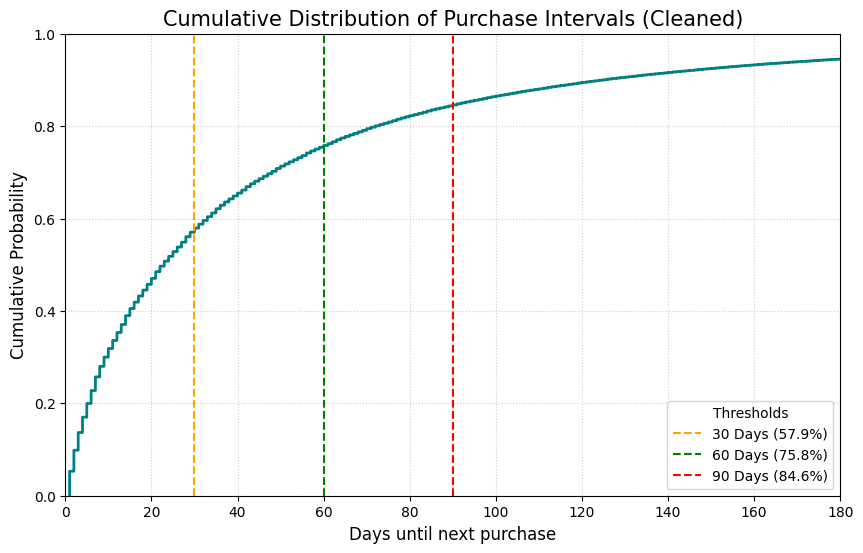

In [13]:
#  고객별 구매 날짜 정렬 후 간격(days_diff) 계산
tmp = transactions.sort_values(['customer_id', 't_dat'])
tmp['prev_purchase'] = tmp.groupby('customer_id')['t_dat'].shift(1)
tmp['days_diff'] = (tmp['t_dat'] - tmp['prev_purchase']).dt.days

# 동시 구매(0일)를 제외한 순수 '재방문' 간격만 추출
diff_data = tmp[tmp['days_diff'] > 0]['days_diff']

# 구간별 누적 재구매 확률 계산
within_30 = (diff_data <= 30).mean()
within_60 = (diff_data <= 60).mean()
within_90 = (diff_data <= 90).mean()

print(f"--- [리셀러 제거 후] 재구매 확률 분석 ---")
print(f"30일 이내 재구매 확률: {within_30:.1%}")
print(f"60일 이내 재구매 확률: {within_60:.1%}")
print(f"90일 이내 재구매 확률: {within_90:.1%}")

# 누적 분포 시각화
plt.figure(figsize=(10, 6))
sns.ecdfplot(diff_data, color='teal', linewidth=2)

# 기준선 표시
plt.axvline(x=30, color='orange', linestyle='--', label=f'30 Days ({within_30:.1%})')
plt.axvline(x=60, color='green', linestyle='--', label=f'60 Days ({within_60:.1%})')
plt.axvline(x=90, color='red', linestyle='--', label=f'90 Days ({within_90:.1%})')

plt.xlim(0, 180) # 6개월까지만 집중 확인
plt.title('Cumulative Distribution of Purchase Intervals (Cleaned)', fontsize=15)
plt.xlabel('Days until next purchase', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.legend(title="Thresholds")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

- 30일 이내 (57.9%) - [핵심 활동기]:
고객 10명 중 6명은 한 달 안에 다시 온다. 이 시기에 신상품 알림을 보내는 것이 가장 효과적.

- 60일 이내 (75.8%) - [이탈 주의보]:
두 달이 지났는데 소식이 없다면, 76%의 확률(재구매가 일어날 대부분의 시점)을 놓친 것. 이때 강력한 혜택(쿠폰 등)을 제공하자.

- 90일 이내 (84.6%) - [이탈 확정 단계]:
90일이 지나면 재구매가 일어날 확률이 15% 미만으로 떨어진다. 이 시점부터는 '이탈 고객'으로 분류하고 관리하는 것이 매우 합리적.

In [14]:
# 기준일(Cut-off) 설정: 마지막 날로부터 90일 전
latest_date = transactions['t_dat'].max()
cut_off_date = latest_date - pd.Timedelta(days=90)

# 기준일 이전 데이터로 RFM 피처 생성
train_df = transactions[transactions['t_dat'] <= cut_off_date]

rfm = train_df.groupby('customer_id').agg({
    't_dat': [
        lambda x: (cut_off_date - x.max()).days, # Recency: 기준일로부터 얼마나 됐나?
        lambda x: (x.max() - x.min()).days       # Lifetime: 총 활동 기간
    ],
    'article_id': 'count',                       # Frequency: 총 구매 건수
    'price': 'sum'                               # Monetary: 총 구매 금액
}).reset_index()

# 컬럼명 정리
rfm.columns = ['customer_id', 'recency', 'lifetime_days', 'frequency', 'monetary']


# 기준일 이후 90일간의 구매 여부 확인 (Target 구간)
# 기준일 이후 90일 동안 한번이라도 물건을 산 사람들의 명단 (active_customers)
target_df = transactions[transactions['t_dat'] > cut_off_date]
active_customers = set(target_df['customer_id'].unique())

# 이탈 라벨링 (90일 이내에 안 나타났으면 이탈 1)
rfm['churn'] = rfm['customer_id'].apply(lambda x: 0 if x in active_customers else 1)

# 유지고객 0  ,  이탈고객 1
print("--- 최종 라벨링 결과 ---")
print(rfm['churn'].value_counts(normalize=True))
print(f"\n최종 데이터셋 크기: {rfm.shape}")

--- 최종 라벨링 결과 ---
churn
1    0.653852
0    0.346148
Name: proportion, dtype: float64

최종 데이터셋 크기: (1289785, 6)


### **데이터 해석**

> 이탈률 65.4% : 90일 동안 다시 오지 않은 고객이 약 65%

> 유지율 34.6% : 10명 중 3.5명은 90일 안에 다시 와서 옷을 삼. '우수 고객 후보군 '


### **거래 데이터**
- 리셀러(이상치)제거 : 구매 건수가 385건 이상의 극단적 고객 명단에서 제외

- 시간대별 필터링 : 기준점 이후 90일간의 구매 기록을 확인하여 이탈 여부(Churn) 라벨링 진행

In [15]:
# 데이터 저장
# 파일 이름을 알아보기 쉽게 저장
rfm.to_csv('hm_churn_base.csv', index=False)